In [1]:
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [2]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/pedro/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [5]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [6]:
y_range = [0,5.5]

In [7]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [8]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss
1,1.612662,0.934185
2,0.851130,0.678263
3,0.664410,0.672462


## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [9]:
Config.data_path()

PosixPath('/home/pedro/.fastai/data')

In [10]:
path=Config.data_path()/'ml-100k'

In [11]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [12]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
len(ratings)

100000

In [14]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [15]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name=title)

In [16]:
data.show_batch()

userId,title,target
326,Die Hard 2 (1990),5.0
379,Star Trek IV: The Voyage Home (1986),4.0
315,"Grifters, The (1990)",5.0
927,High School High (1996),2.0
436,Cop Land (1997),5.0


In [17]:
y_range = [0,5.5]

In [18]:
del(learn)
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07


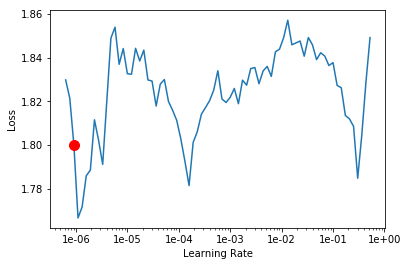

In [19]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
#learn.fit_one_cycle(5, 5e-3)
learn.fit_one_cycle(5, 6e-2)

In [ ]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [ ]:
learn.load('dotprod');

In [ ]:
learn.model

In [ ]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

### Movie bias

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

In [ ]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]

In [ ]:
sorted(movie_ratings, key=item0)[:15]

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

### Movie weights

In [ ]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()